# Problem Statement

The problem is predicting whether a new user will remain active on Zindi in their second month after signing up. This is a binary classification problem, where the target variable is “active in the second month” ('1'/'0').

- Importance of the Problem:
    - User Retention Insights: Retaining users is a critical metric for any platform. Knowing which users are likely to churn or remain active allows the company to tailor engagement strategies.

    - Improving User Experience: If we can identify users who might drop off early, interventions (like personalized recommendations, emails, or onboarding tips) can be applied to improve their experience.


### How an ML Model Can Help:
    - Proactive Engagement
    - Data-Driven Decisions
    - Cost Reduction
    - Performance Tracking

In [4]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import matplotlib.pyplot as plt
from train import load_dataset,train
from data_preprocessing.merge import merge
import os
from data_preprocessing.visualization_modular import data_overview, numeric_feature_distributions, correlation_and_feature_importance, pca_analysis, tsne_analysis,plot_feature_distributions,display_visualizations


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Merging Tables, Formulating Target Column and Splitting Test Set
- Align user timelines by remapping the event months back to the original calendar, reconstructing exact signup and activity timestamps so downstream models reason over real chronological gaps.

- Aggregate behavioural intensity features (visit counts, activity-day variety, job/competition/blog interactions, badge tallies, residual activity categories) to capture how engaged a user was during their signup month.

- Build richer participation signals from competition submissions, discussion threads, and comments, tying them to the user’s signup window to reflect early community involvement.

- Encode geography and merge all user-centric signals onto the user table so each row represents a participant with a comprehensive behavioural footprint.

- Derive the training target by checking whether a user reappears in platform interactions the following month, then export aligned train/test matrices for modeling.

In [10]:
merge(os.path.join(os.getcwd(),"data"))

# Load Dataset
Load the engineered training table and preview the first rows to sanity-check column names, data types, and the presence of the target before diving into diagnostics. This snapshot often reveals unexpected preprocessing issues early.


In [5]:
import pandas as pd
df = pd.read_csv("data/datatrain.csv")
df.head()

,FeatureX,FeatureY,User_ID,Countries_ID,Created At time,Created At Year,Created At Month,Created At Day_of_month,days_left_in_month,visit_std,...,subm count 3,subm count 8,subm count 9,subm count 6,subm count 7,subm count 5,subm count 4,comments_count,discussions_count,target
0,0,0,ID_DC6S4E9O,135,19:33:13.663391,1,1,16,14,0.0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,ID_E8S97OUT,135,22:18:18.228921,1,12,27,4,0.0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,ID_QZ1HASL3,135,23:13:03.266635,1,1,1,29,2.0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,ID_SDV9Q3E9,135,09:50:09.697573,1,12,27,4,0.0,...,0,0,0,0,0,0,0,0,0,1
4,1,0,ID_W942LN7F,135,13:33:06.531662,1,1,16,14,3.0,...,0,0,0,0,0,0,0,2,0,1


# EDA
Run the overview utility to quantify class balance, missing data, and descriptive stats. These summaries show whether the engagement label is imbalanced, which features might need imputation, and how spreads differ across metrics. It was noticed that more than half of the Countries_ID column was nulls, also the created at year was all the same so we dropped both. It was shown that target is imbalanced.



In [4]:
data_overview(df)

Target value distribution (normalized):


target
0    0.729599
1    0.270401
Name: proportion, dtype: float64

Missing values per column:


FeatureX             0
FeatureY             0
User_ID              0
Countries_ID         0
Created At time      0
                    ..
subm count 5         0
subm count 4         0
comments_count       0
discussions_count    0
target               0
Length: 63, dtype: int64

Summary statistics:


,FeatureX,FeatureY,Countries_ID,Created At Year,Created At Month,Created At Day_of_month,days_left_in_month,visit_std,visit_count,job_activity_count,...,subm count 3,subm count 8,subm count 9,subm count 6,subm count 7,subm count 5,subm count 4,comments_count,discussions_count,target
count,9068.000000,9068.000000,9068.000000,9068.0,9068.000000,9068.000000,9068.000000,9068.000000,9068.000000,9068.000000,...,9068.000000,9068.000000,9068.000000,9068.000000,9068.000000,9068.000000,9068.000000,9068.000000,9068.000000,9068.000000
mean,0.088994,0.488972,108.221217,1.0,5.502206,16.804257,13.886083,0.625827,18.679863,0.096714,...,0.001544,0.005073,0.003198,0.010587,0.001654,0.000993,0.000662,0.015439,0.104874,0.270401
std,0.284751,0.843291,50.415046,0.0,4.612131,9.435668,9.403902,1.583785,25.923043,0.633795,...,0.039264,0.071047,0.058385,0.104484,0.040640,0.031490,0.025716,0.240821,0.450392,0.444192
min,0.000000,0.000000,0.000000,1.0,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,60.000000,1.0,2.000000,8.000000,5.000000,0.000000,8.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,135.000000,1.0,3.000000,18.000000,12.000000,0.000000,12.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,146.000000,1.0,11.000000,26.000000,23.000000,0.000000,21.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,3.000000,146.000000,1.0,12.000000,31.000000,30.000000,12.000000,885.000000,19.000000,...,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,1.000000,11.000000,12.000000,1.000000



# Correlation & Feature Importance
Inspect Pearson correlations alongside mutual-information scores to see which signals move linearly with the target and which capture non-linear relationships. This informs feature selection in case there was linear relationship 


Correlation of numeric features with target:
Mutual information scores for numeric features:


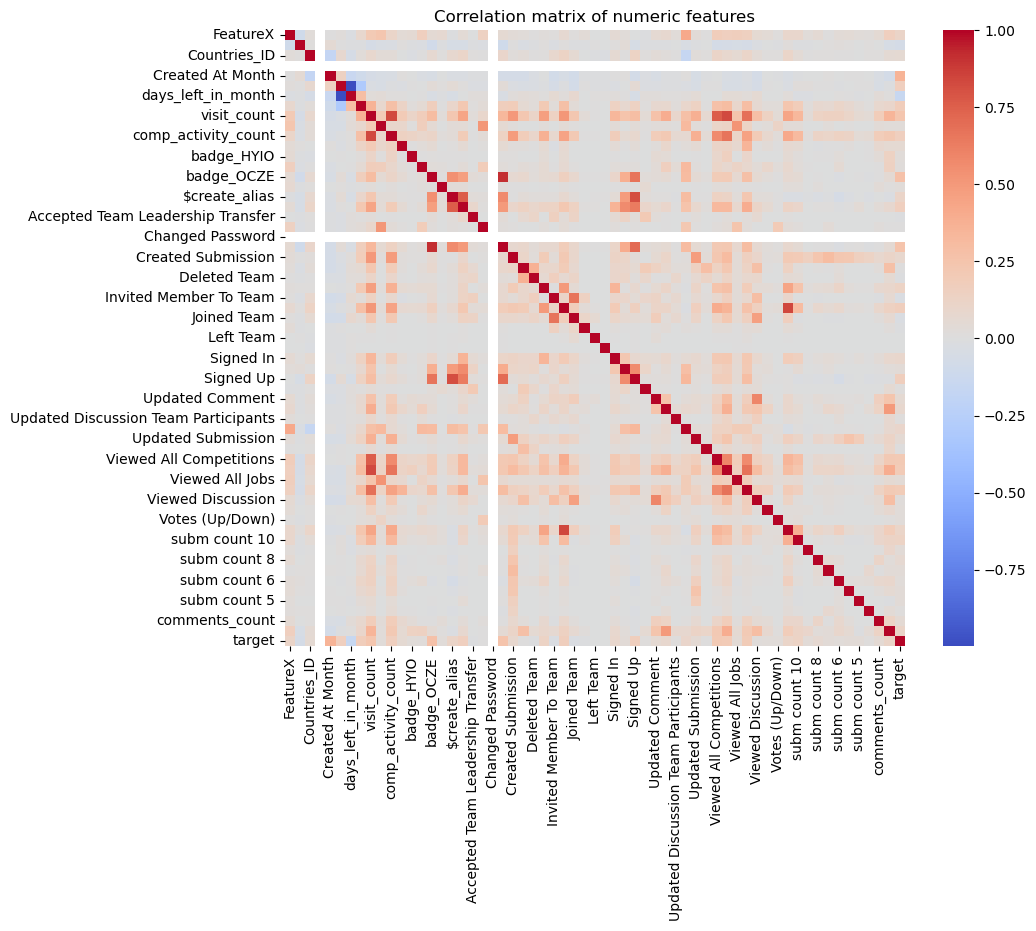

In [3]:
correlation_and_feature_importance(df)

# Feature Distribution and Box Plot
Plot histograms and box plots for the most informative features to understand skew, heavy tails, and median shifts between classes. These visuals highlight potential thresholds, outliers, or what features show most seperation.


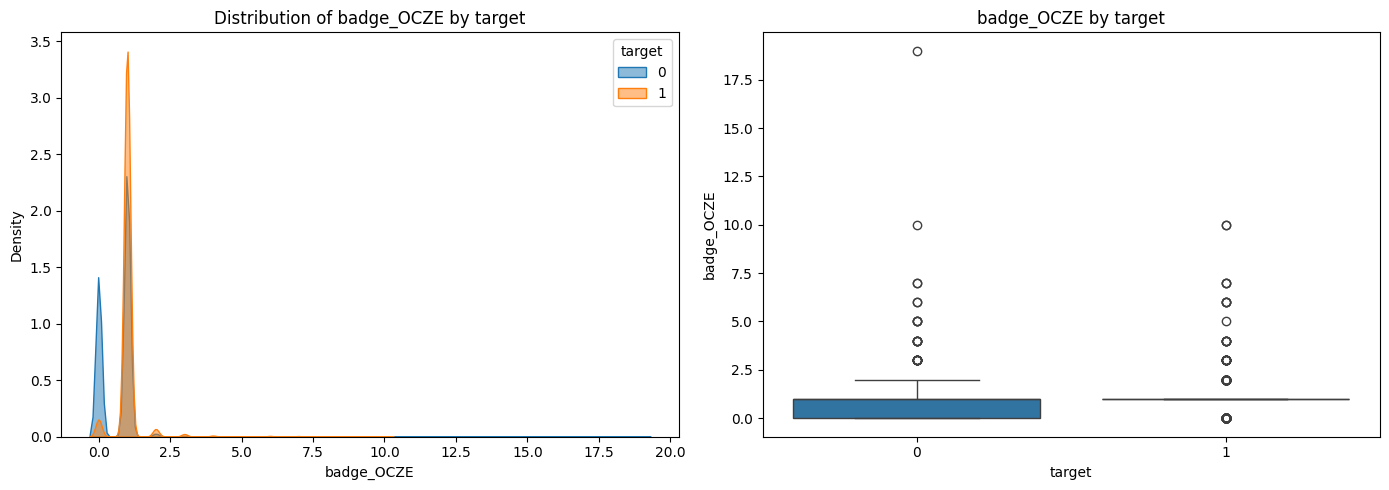

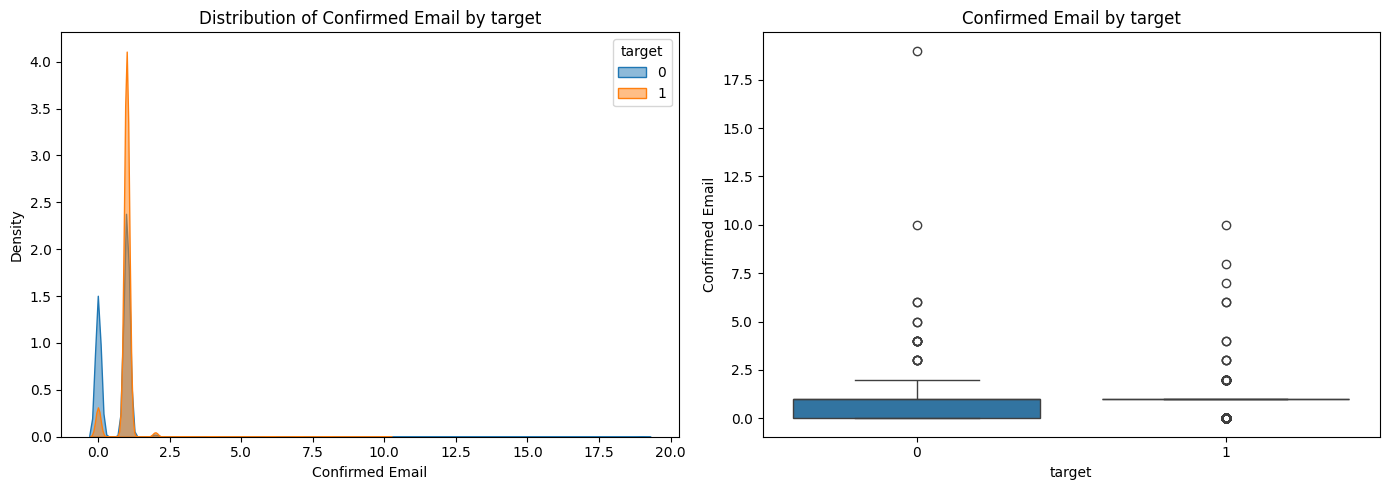

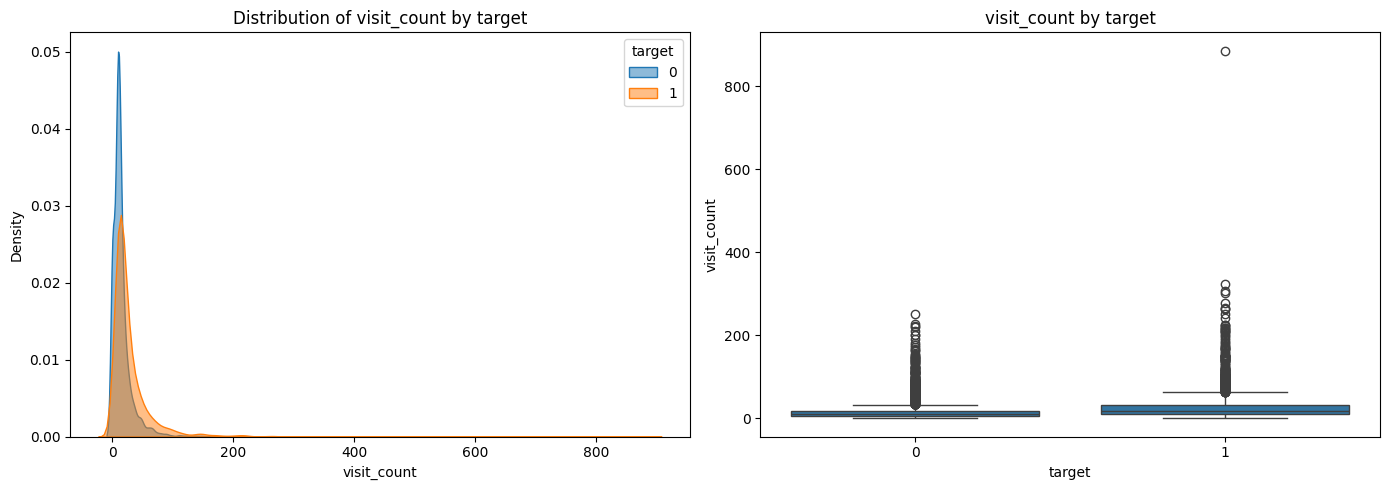

In [7]:
# plot_feature_distributions(df)
display_visualizations()


# PCA Analysis
Compute PCA projections to measure how many orthogonal components explain the bulk of variance and to visualize reconstruction error. If a handful of components capture most structure, dimensionality reduction could simplify downstream models. However in our case no bulk of variance was noticed across different values of dimensions for PCA indicating that PCA didnt provide any beneficial dimension reduction


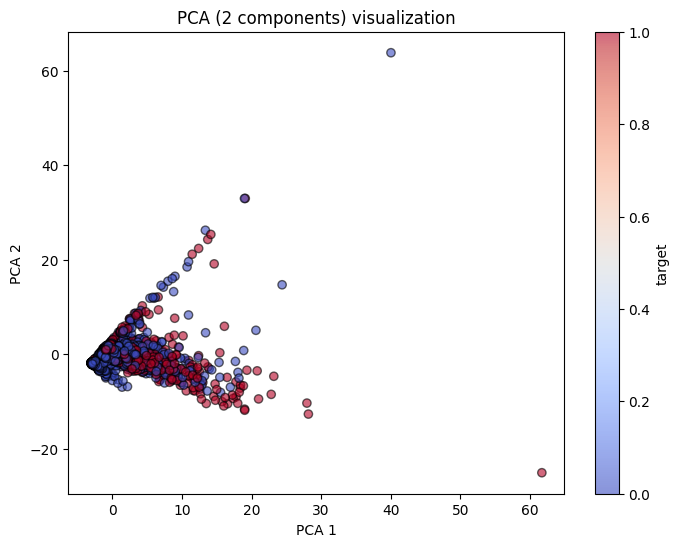

For 2 components:
Reconstruction MSE: 47.31775624226746
Explained variance ratio: [0.12214433 0.06418973]
Cumulative variance explained: 0.18633405713936704
For 3 components:
Reconstruction MSE: 46.73471310900285
Explained variance ratio: [0.12214433 0.06418973 0.04046736]
Cumulative variance explained: 0.22680142062993228
For 4 components:
Reconstruction MSE: 45.3080221699042
Explained variance ratio: [0.12214433 0.06418973 0.04046736 0.03971032]
Cumulative variance explained: 0.266511740568892
For 5 components:
Reconstruction MSE: 43.5196392534702
Explained variance ratio: [0.12214433 0.06418973 0.04046736 0.03971032 0.03649281]
Cumulative variance explained: 0.30300455034962154
For 6 components:
Reconstruction MSE: 41.88236404360643
Explained variance ratio: [0.12214433 0.06418973 0.04046736 0.03971032 0.03649281 0.03016412]
Cumulative variance explained: 0.3331686744051817
For 7 components:
Reconstruction MSE: 41.60499963707799
Explained variance ratio: [0.12214433 0.06418973 0.040

In [7]:
pca_analysis(df)



# t-SNE Analysis
Use t-SNE embeddings to explore whether active versus inactive users form separable clusters in a non-linear manifold. Clear separation suggests the features contain discriminative patterns worth investigating further. There was no clear seperation noticed from the t-SNE indicating that it wasnt able to find proper seperation between classes


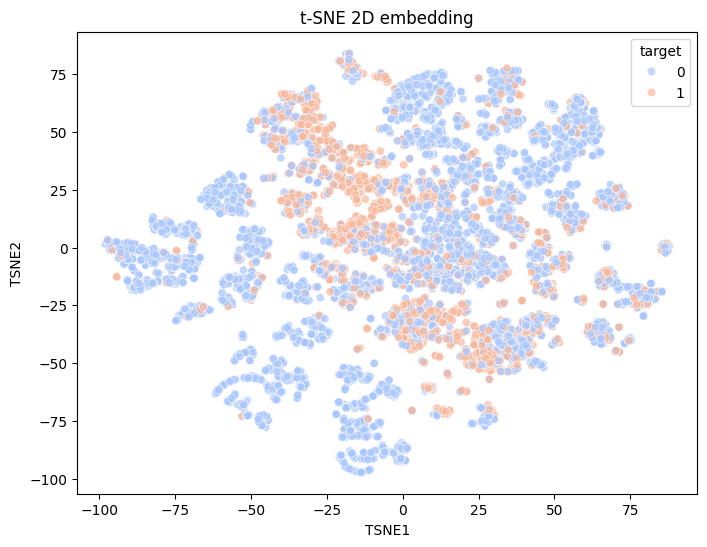

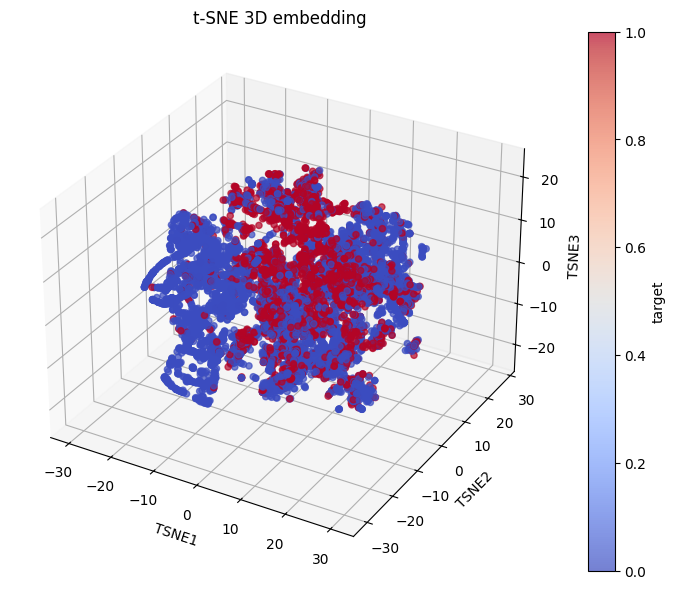

In [8]:
tsne_analysis(df)

Data Loading and Model Training Pipeline

- Data Preparation (load_dataset):
    - The load_dataset function loads and preprocesses the training and test datasets. It reads user engagement data from CSV files, selects relevant numerical features, and removes columns that are not useful for modeling (such as user IDs, time, and country information). This ensures the models are trained only on meaningful predictors.

In [11]:
X,Y,test = load_dataset()

Model Training and Stacking Overview

The train function implements a multi-stage model training pipeline using stacking, a powerful ensemble technique. The main steps are:

- Logistic Regression Training:

    - Trains a Logistic Regression with class balance to address class imbalance and generate initial predictions.


- CatBoost Stacking:

    - Combines outputs from previous models (logistic regression) as new features, then trains a CatBoost classifier. This stacking approach allows the model to learn from the strengths and weaknesses of each base model, capturing complex patterns and improving generalization.

- Weighted Averaging:
    - Averages predictions from logistic regression and CatBoost to create a robust meta-feature.
    - Also, we perfomed hard-exmaple removal for the zero class using the prediction of the past models to remove any outliers. We did not perform it on the "one" class as it is the minority.

- Final CatBoost Model:
    - Trains a final CatBoost classifier on the stacked features, optimizing for performance and reporting precision, recall, and F1 scores.

- Motivation for Stacking:
    - Stacking leverages the diversity of multiple models, combining their predictions to reduce bias and variance. Unlike using a single model, stacking can capture non-linear relationships and interactions that individual models may miss, leading to improved accuracy and robustness—especially in complex, imbalanced datasets.


- Cross-Validation and Stratification:
    - Each model is trained and validated using stratified k-fold cross-validation. Stratification ensures that each fold maintains the same class distribution as the full dataset, which is crucial for imbalanced classification problems. This approach provides reliable performance estimates and helps prevent overfitting.

- Motivation for Stacking:
    - Stacking leverages the diversity of multiple models, combining their predictions to reduce bias and variance. Unlike using a single model, stacking can capture non-linear relationships and interactions that individual models may miss, leading to improved accuracy and robustness—especially in complex, imbalanced datasets.



In [13]:
predictions,model = train(X,Y,test,5)

BalancedRF Fold 1
BalancedRF Fold 2
BalancedRF Fold 3
BalancedRF Fold 4
BalancedRF Fold 5
Logistic Regression Fold 1
Logistic Regression Fold 2
Logistic Regression Fold 3
Logistic Regression Fold 4
Logistic Regression Fold 5
CatBoost (stacking) Fold 1
0:	learn: 0.6873133	test: 0.6877467	best: 0.6877467 (0)	total: 54.3ms	remaining: 54.3s
100:	learn: 0.4654103	test: 0.4794544	best: 0.4794544 (100)	total: 674ms	remaining: 6s
200:	learn: 0.4160762	test: 0.4383233	best: 0.4383233 (200)	total: 1.25s	remaining: 4.96s
300:	learn: 0.3940250	test: 0.4243640	best: 0.4243625 (299)	total: 1.86s	remaining: 4.33s
400:	learn: 0.3801867	test: 0.4171228	best: 0.4171228 (400)	total: 2.46s	remaining: 3.67s
500:	learn: 0.3689432	test: 0.4129011	best: 0.4129011 (500)	total: 3.02s	remaining: 3.01s
600:	learn: 0.3590784	test: 0.4090156	best: 0.4090117 (599)	total: 3.6s	remaining: 2.39s
700:	learn: 0.3501485	test: 0.4058290	best: 0.4058290 (700)	total: 4.17s	remaining: 1.78s
800:	learn: 0.3405450	test: 0.40200

In [27]:

def plot_feature_importance(model, top_n=20, figsize=(10,6)):
    importance = model.feature_importances_
    feature_names = model.feature_names_
    print(len(importance))

    
    df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    })
    
    df = df.sort_values(by='Importance', ascending=False).head(top_n)
    
    plt.figure(figsize=figsize)
    plt.barh(df['Feature'][::-1], df['Importance'][::-1], color='skyblue')
    plt.xlabel('Importance')
    plt.title('CatBoost Feature Importance')
    plt.show()


60


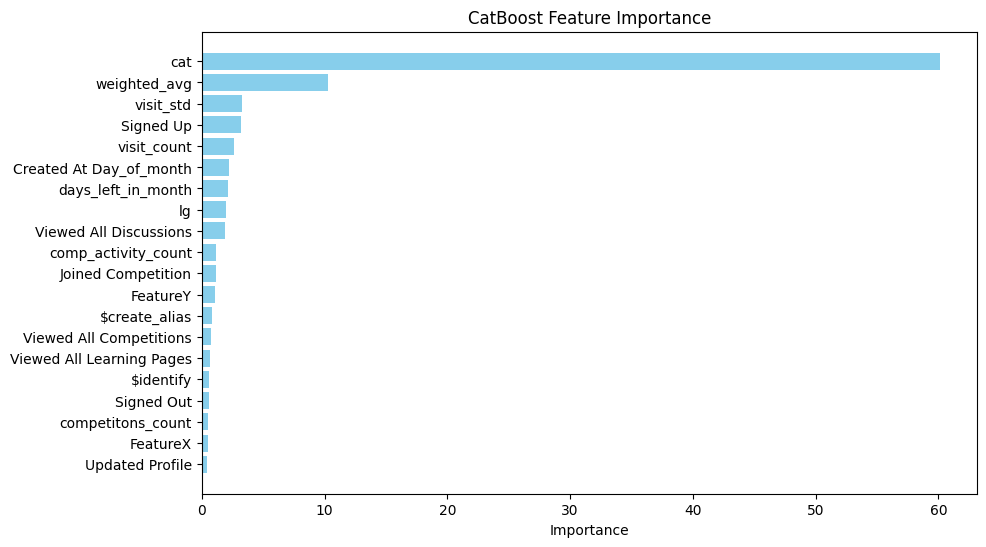

In [28]:
plot_feature_importance(model)

In [ ]:
predictions_bool = (predictions > 0.2).astype('int')
predictions_bool.sum()

np.int64(384)

In [34]:
test_df = pd.read_csv("data/datatest.csv")
sub = pd.DataFrame({
    'User_ID_Next_month_Activity': test_df.User_ID,
    'Active': predictions_bool
})
sub.User_ID_Next_month_Activity = sub.User_ID_Next_month_Activity + '_Month_5'
SampleSubmission = pd.read_csv("data/SampleSubmission.csv")
sub = pd.merge(SampleSubmission.drop(columns='Active'), sub, on='User_ID_Next_month_Activity', how='left').fillna(0)
sub.to_csv("stacked_submission.csv", index=False)


Analysis of Results

Validation / Training Performance:

    - Class 0 (Inactive): F1 ≈ 0.91

    - Class 1 (Active): F1 ≈ 0.77

    - Overall accuracy ≈ 0.87, Macro F1 ≈ 0.84

Training and validation scores are close, suggesting good generalization on the internal data.

Test Set Performance:

    - F1 = 0.42 (significantly lower than validation), indicating that the model struggles to generalize to unseen users.

    - Likely causes: distribution shift between the training/validation cohort and the test cohort, or class imbalance.

Remarks:

    - The model predicts inactive users reliably but is much less effective for active users in the real-world test.

    - First-month behavior features are still the main drivers, but they may not fully capture patterns in the new cohort.

Applicability and Impact:

    - In theory, the model could be used for targeted retention strategies.

    - Limitation: The low test F1 suggests that interventions based on these predictions could be unreliable without retraining or better feature engineering.

Conclusion

    - While the model performs well on internal validation, the test set results show poor generalization. This indicates that, as-is, the model cannot fully solve the retention prediction problem for real-world deployment. Improvements such as handling cohort differences, better feature selection, or temporal validation are needed before practical use.